In [1]:
import torch
import pickle
import numpy as np
import sys
sys.path.append('./../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import HTML
from matplotlib import style
#rc('animation', html='html5')

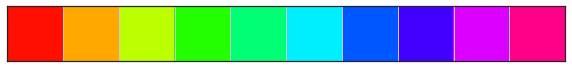

In [3]:
import seaborn as sns
sns.set()
sns.set_style('white')
#sns.set_style('whitegrid')
import matplotlib
plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
#plt.rc('font', weight='bold')

#current_palette = sns.color_palette(sns.hls_palette(10+1, l=.5, s=1.0))
#current_palette = sns.color_palette(sns.hls_palette(21+1, l=.5, s=1.0))
current_palette = sns.color_palette(sns.hls_palette(10, l=.5, s=1.0))


#current_palette = sns.palplot(sns.hls_palette("bright", l=.5, s=1.0))
#current_palette = np.asarray(sns.color_palette("deep"))
#current_palette[0] 
base_c = [0.00784314, 0.24313725, 1. ]

sns.palplot(current_palette)


In [38]:
from utility.dataset import _process_Synthetic
from models_utility.construct_models import _combine_models
from utility.eval_metric import _measure_metric, accuracy
#torch.set_default_tensor_type(torch.FloatTensor)




file_path = './dataset/synthetic/'
file_name = 'Q6_Fs1000'
data_file_path = file_path + file_name


##############################################################################
# load dataset
##############################################################################
random_seed = 1000
num_exp = 2


###############################################
###############################################

exp_setting = {}
exp_setting['device'] = False

exp_setting['num_rep_exp'] = num_exp
exp_setting['data'] = file_name
exp_setting['full_length'] = 100

exp_setting['input_dim'] = 1
exp_setting['Num_HiddenState'] = 8
exp_setting['Num_Q'] = 5



x_train, y_train, z_train, x_test,y_test,z_test, true_freq , true_weight , true_noise_level ,true_num_state = _process_Synthetic(data_file_path,exp_setting)

exp_setting['input_length'] = x_train.shape[1]
z_test -= 1
z_train -= 1


### For images figures

In [39]:
#z_train =2
downsamples = 4
import random
#idx = np.sort(random.sample(range(50),5))
idx = [11, 13, 15, 22, 44]
#z_train[idx]
temp_fig_size = (6*5,2.5)

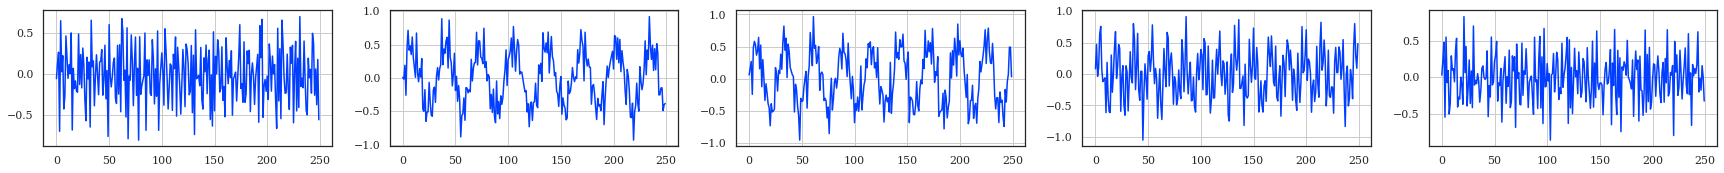

In [40]:
plt.figure(figsize=temp_fig_size ) 
for ith,(ith_y,ith_z) in enumerate(zip(y_train[idx],z_train[idx])):    
    plt.subplot(1,5,ith+1)
    plt.plot(ith_y[::downsamples],color = base_c  )
    plt.grid('off')

In [41]:
z_train[idx]

array([1, 2, 2, 4, 1], dtype=uint8)

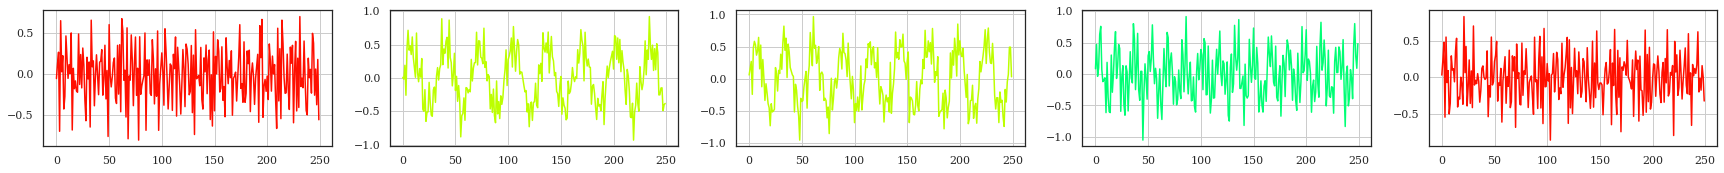

In [42]:
plt.figure(figsize=temp_fig_size ) 
for ith,(ith_y,ith_z) in enumerate(zip(y_train[idx],z_train[idx])):    
    plt.subplot(1,5,ith+1)
    if ith_z == 1:
        ith_z = 0
    plt.plot(ith_y[::downsamples],color =  current_palette[ith_z]  )
    plt.grid('off')
plt.savefig('./temp'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')


In [43]:
###############################################################################################
# Model Setting
###############################################################################################


HMMGP_setting = {}
#HMMGP_setting['emission'] = 'gpsm' #
HMMGP_setting['emission'] = 'gprrff_beta' #
#HMMGP_setting['emission'] = 'benchmark_v3'  #Q=4



HMMGP_setting['Num_Q'] = exp_setting['Num_Q']


#HMMGP_setting['train'] = 'VBEM' #
HMMGP_setting['train'] = 'SVI' #
HMMGP_setting['lr_A'] = 0.05
HMMGP_setting['lr_pi'] = 0.05
HMMGP_setting['lr_hyp'] = 0.005 #for beta


HMMGP_setting['Len_Full'] = exp_setting['full_length']
if HMMGP_setting['train'] == 'VBEM':
    HMMGP_setting['Len_Batch'] = HMMGP_setting['Len_Full']
    HMMGP_setting['Num_Batch'] = 1
else:
    HMMGP_setting['Len_Batch'] = 10
    HMMGP_setting['Num_Batch'] = 1


HMMGP_setting['Iter_train'] = 30 #for beta
HMMGP_setting['Iter_hyp'] = 10 #for beta


HMMGP_setting['Rate_RRFFSpectralPt'] = 0.1
HMMGP_setting['Num_RRFFSpectralPt_total'] = int((exp_setting['input_length'] * HMMGP_setting['Rate_RRFFSpectralPt']))
HMMGP_setting['Num_RRFFBatch'] = 1
HMMGP_setting['Num_K_Emission'] = 3



HMMGP_setting['device'] = exp_setting['device']


print('input_length : %d'%(exp_setting['input_length']))
print('Num_RRFFSpectralPt : %d'%(int ( (exp_setting['input_length']*HMMGP_setting['Rate_RRFFSpectralPt']) )))
print('train : %s, emission : %s, num Q : %d, total spt: %d, rate : %.2f'
      %(HMMGP_setting['train'],HMMGP_setting['emission'],HMMGP_setting['Num_Q'],HMMGP_setting['Num_RRFFSpectralPt_total'],HMMGP_setting['Rate_RRFFSpectralPt']))



input_length : 1000
Num_RRFFSpectralPt : 100
train : SVI, emission : gprrff_beta, num Q : 5, total spt: 100, rate : 0.10


In [44]:
#model = _combine_models(x_train, y_train, exp_setting, HMMGP_setting,random_seed=random_seed,num_init_iter = 501)


In [45]:
# print(*model.emission_model_list[0].parameters())

## training

In [46]:
for i_th in range(exp_setting['num_rep_exp']):    
    print('#' * 100)

    #model = _combine_models(x_train, y_train, exp_setting, HMMGP_setting,random_seed=random_seed,num_init_iter = 5)
    #model = _combine_models(x_train, y_train, exp_setting, HMMGP_setting,random_seed=random_seed,num_init_iter = 501) #기존업데이트
    model = _combine_models(x_train, y_train, exp_setting, HMMGP_setting,random_seed=random_seed,num_init_iter = 501)
    
    train_loglik_list, train_accuracy_list, test_accuracy_list, test_exact_accuracy_list, \
    time_list, num_cluster_list, num_test_cluster_list, num_test_exact_cluster_list, param_history_dict = model.train(x_train, y_train, z_train, x_test, y_test, z_test)

z_test_pred, test_elbo ,test_lik = model._run_smoothing(x_test, y_test, num_test_batch=HMMGP_setting['Num_K_Emission'], test_option=True)
    


####################################################################################################
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
initialization_beta_rrff
8
0 emission, 0 iter, loss 37570.0554 
0 emission, 50 iter, loss 15292.6269 
0 emission, 100 iter, loss 10925.6729 
0 emission, 150 iter, loss 7114.6237 
0 emission, 200 iter, loss 5582.1929 
0 emission, 250 iter, loss 4120.8447 
0 emission, 300 iter, loss 3227.5151 
0 emission, 350 iter, loss 2246.3312 
0 emission, 400 iter, loss 1807.9467 
0 emission, 450 iter, loss 1355.0958 
0 emission, 500 iter, loss 922.1643 

6
1 emission, 0 iter, loss 58887.7692 
1 emission, 50 iter, loss 5905.4222 
1 emission, 100 iter, loss 4648.8219 
1 emission, 150 iter, loss 3518.6438 
1 emission, 200 iter, loss 2564.4737 
1 emission, 250 iter, loss 1813.1116 
1 emission, 300 iter, loss 1237.1381 
1 emission, 3

----------------------------------------------------------------------------------------------------
iter 16, iteration time : 3.122| train acc : 0.830, train lik : -276734.742, 	 test acc : 0.700, test lik : -1662183.871 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
iter 17, iteration time : 3.116| train acc : 0.730, train lik : -186101.531, 	 test acc : 0.720, test lik : -1414960.030 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
iter 18, iteration time : 3.122| train acc : 0.760, train lik : -173329.146, 	 test acc : 0.700, test lik : -1750095.606 
----------------------------------------------------------------------------------------------------
----------------------------

7 emission, 150 iter, loss 4720.7280 
7 emission, 200 iter, loss 3680.1409 
7 emission, 250 iter, loss 2589.1986 
7 emission, 300 iter, loss 1915.8001 
7 emission, 350 iter, loss 1596.2220 
7 emission, 400 iter, loss 1158.4127 
7 emission, 450 iter, loss 808.9861 
7 emission, 500 iter, loss 574.0817 

----------------------------------------------------------------------------------------------------
iter 1, iteration time : 3.171| train acc : 0.680, train lik : -1030169.073, 	 test acc : 0.580, test lik : -4062325.997 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
iter 2, iteration time : 3.215| train acc : 0.650, train lik : -829346.988, 	 test acc : 0.640, test lik : -3524751.873 
----------------------------------------------------------------------------------------------------
--------------------------------------------------

----------------------------------------------------------------------------------------------------
iter 26, iteration time : 3.206| train acc : 0.740, train lik : -70775.261, 	 test acc : 0.760, test lik : -789055.190 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
iter 27, iteration time : 3.212| train acc : 0.800, train lik : -50802.690, 	 test acc : 0.700, test lik : -1041918.946 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
iter 28, iteration time : 3.222| train acc : 0.810, train lik : -47990.696, 	 test acc : 0.760, test lik : -934297.648 
----------------------------------------------------------------------------------------------------
---------------------------------

In [ ]:
# z_test_pred, test_elbo ,test_lik = model._run_smoothing(x_test, y_test, num_test_batch=HMMGP_setting['Num_K_Emission'], test_option=True)


In [58]:
train_loglik_list.shape

(30, 4)

In [47]:
train_elbo,train_lik,test_elbo,test_lik = train_loglik_list[:,0],train_loglik_list[:,1],train_loglik_list[:,2],train_loglik_list[:,3]

In [62]:
train_elbo[-1],train_lik[-1],test_elbo[-1],test_lik[-1]

(-411606.07511556434,
 -68220.69071452697,
 -2963900.8274975438,
 -873405.9283146564)

In [63]:
figsiz2 = (20,2) 
labelsiz = 15
fontsiz = 20
interval = 0.2
xlimit_range = [105,145]

In [64]:
#z_test_pred = result_pickle['test_pred'][chosen_idx]
revised_order_dict, revised_z_test_pred, _ = _measure_metric(z_test, z_test_pred)
revised_z_test_pred = revised_z_test_pred

In [65]:
ith_z

3

## test set

No handles with labels found to put in legend.


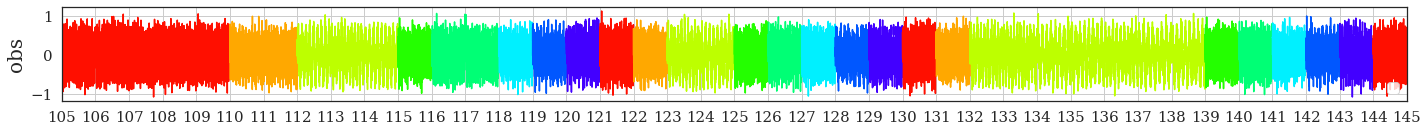

In [66]:

fig = plt.figure(figsize = figsiz2 )
for ith,(ith_x,ith_y,ith_z) in enumerate(zip(x_test,y_test,z_test)):
    plt.plot( ith_x , ith_y , color = current_palette[ith_z])
    #plt.plot( ith_x , ith_y , color = current_palette[ith_z])
    #print(ith_x + ith)
    #plt.plot(ith + ith_x, ith_y , color = current_palette[ith_z])

#plt.title('true')
plt.tick_params(labelsize=labelsiz) 
plt.xlim(xlimit_range)

plt.ylabel('obs',fontsize = fontsiz)

plt.xticks(np.arange(xlimit_range[0],xlimit_range[1]+1),fontsize = 15 )
plt.yticks(fontsize = 15)

#plt.xlabel('log10 training time (sec)',fontsize = fontsiz)
plt.legend(loc='lower right',fontsize = 15)
fig.tight_layout()    

#plt.savefig(save_figure_path + model_name + '_true' + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()



## estimation for test set

No handles with labels found to put in legend.


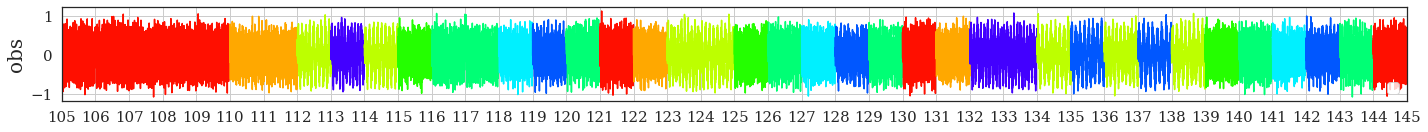

In [67]:
fig = plt.figure(figsize = figsiz2 )
for ith,(ith_x,ith_y,ith_z) in enumerate( zip(x_test,y_test,revised_z_test_pred)):
#for ith,(ith_x,ith_y,ith_z) in enumerate( zip(x_test,y_test,z_test_pred)):
    plt.plot( ith_x , ith_y , color = current_palette[ith_z])

#    plt.plot( ith_x, ith_y , color = current_palette[ith_z])

plt.tick_params(labelsize=labelsiz) 
plt.xlim(xlimit_range)

plt.ylabel('obs',fontsize = fontsiz)
# plt.xlabel('time',fontsize = fontsiz)
plt.xticks(np.arange(xlimit_range[0],xlimit_range[1]+1),fontsize = 15 )
plt.yticks(fontsize = 15)

#plt.xlabel('log10 training time (sec)',fontsize = fontsiz)
plt.legend(loc='lower right',fontsize = 15)
fig.tight_layout()    

#plt.savefig(save_figure_path + model_name + '_pred'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()


No handles with labels found to put in legend.


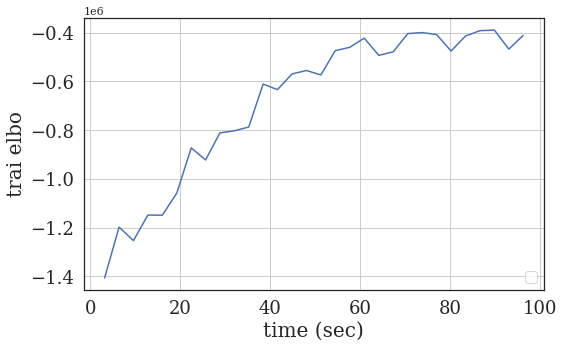

No handles with labels found to put in legend.


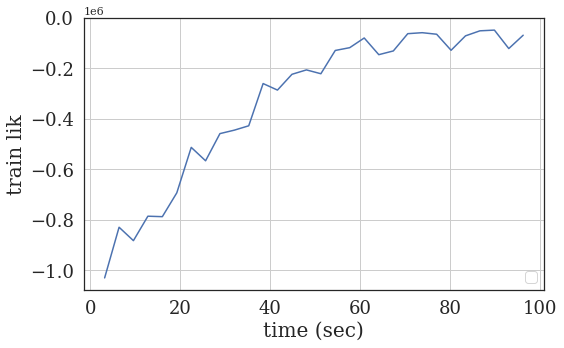

No handles with labels found to put in legend.


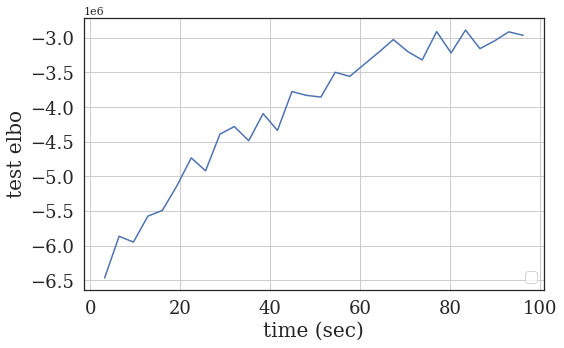

No handles with labels found to put in legend.


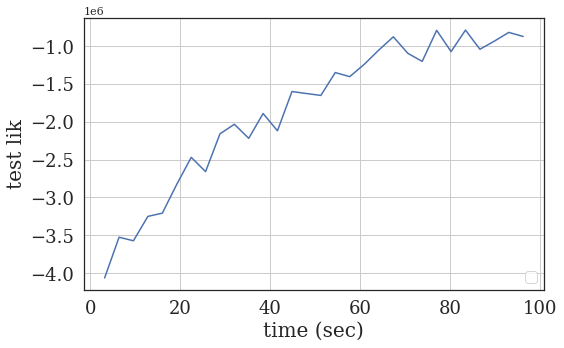

In [68]:
#train_loglik_list,train_accuracy_list, 
figsiz = (8,5) 
#figsiz = (6,4) 
labelsiz = 15
fontsiz = 15
interval = 0.2

fig = plt.figure(figsize = figsiz)
#plt.plot(time_list.cumsum(),train_loglik_list)
plt.plot(time_list.cumsum(),train_elbo)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#plt.xscale('log',basex=10) 
plt.ylabel('trai elbo',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()

fig = plt.figure(figsize = figsiz)
#plt.plot(time_list.cumsum(),train_loglik_list)
plt.plot(time_list.cumsum(),train_lik)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#plt.xscale('log',basex=10) 
plt.ylabel('train lik',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()


fig = plt.figure(figsize = figsiz)
#plt.plot(time_list.cumsum(),train_loglik_list)
plt.plot(time_list.cumsum(),test_elbo)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#plt.xscale('log',basex=10) 
plt.ylabel('test elbo',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()


fig = plt.figure(figsize = figsiz)
#plt.plot(time_list.cumsum(),train_loglik_list)
plt.plot(time_list.cumsum(),test_lik)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#plt.xscale('log',basex=10) 
plt.ylabel('test lik',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()





No handles with labels found to put in legend.


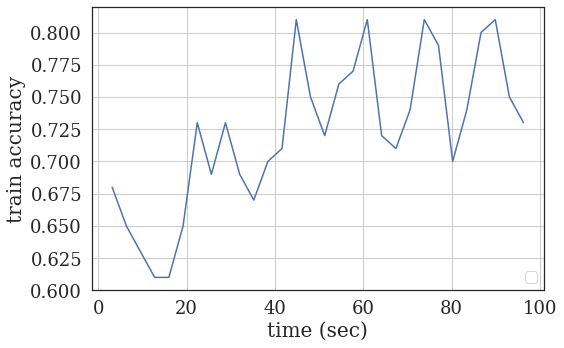

No handles with labels found to put in legend.


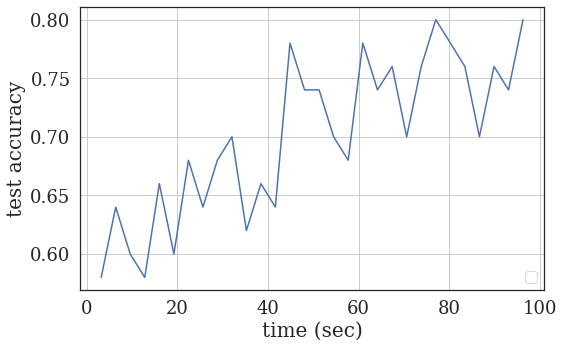

In [69]:
figsiz = (8,5) 
#figsiz = (6,4) 
labelsiz = 15
fontsiz = 15
interval = 0.2

fig = plt.figure(figsize = figsiz)
plt.plot(time_list.cumsum(),train_accuracy_list)
#plt.xscale('log',basex=10) 
plt.ylabel('train accuracy',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()


figsiz = (8,5) 
#figsiz = (6,4) 
labelsiz = 15
fontsiz = 15
interval = 0.2

fig = plt.figure(figsize = figsiz)
plt.plot(time_list.cumsum(),test_accuracy_list)
#plt.xscale('log',basex=10) 
plt.ylabel('test accuracy',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()


## spectral density estimation 

/home/yohan/Myenv/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/yohan/Myenv/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


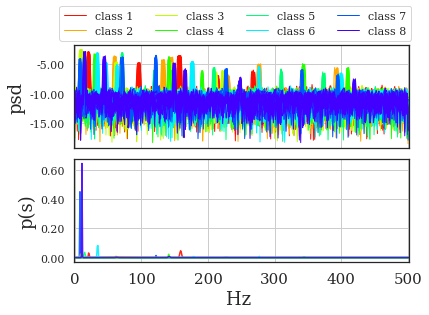

In [72]:
xlim_range = [0-1,500 + 1]

from scipy import signal
from scipy import  stats
from matplotlib.ticker import FormatStrFormatter



figsiz = (15,8) 
#figsiz = (6,3)
labelsiz = 15
fontsiz = 15
interval = 0.2

Fs = len(x_train[0])
fig,axs =  plt.subplots( 2, sharex=True , gridspec_kw={'hspace': 0.1})
ax1,ax2 = axs[0],axs[1]


for ith_z in range(10):
    #print(np.where(z_train==ith_z)[0][:3])
    for j,jth in enumerate(np.where(z_train==ith_z)[0][:]):
        freqs, psd = signal.welch(y_train[jth], fs= Fs ,nperseg= len(y_train[jth]) )        
        if j == 0:
            #ax1.plot(freqs, psd , color = current_palette[ith_z] , linewidth = 1 ,alpha = 1.0 ,label = 'class ' + str(ith_z + 1) )
            ax1.plot(freqs, np.log(psd+1e-8) , color = current_palette[ith_z] , linewidth = 1 ,alpha = 1.0 ,label = 'class ' + str(ith_z + 1) )
            
        else:
            #ax1.plot(freqs, psd , color = current_palette[ith_z] , linewidth = 1 , alpha = 1.0  )
            ax1.plot(freqs, np.log(psd+1e-8) , color = current_palette[ith_z] , linewidth = 1 , alpha = 1.0  )
    
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.legend(bbox_to_anchor=(-0.05,1.02,1,0.1), loc="lower left", borderaxespad = 0.2 ,ncol = 4 ,fontsize = 11)
#ax1.legend(bbox_to_anchor=(1.04,0.5), loc="lower left", borderaxespad=0 ,ncol = 1 ,fontsize = 10)
fig.tight_layout()    
ax1.set_ylabel('psd',fontsize = 18)


#chosen_idx = 0
current_iter = HMMGP_setting['Iter_train']-1 
x = np.arange(512)
for ith_emission in range(exp_setting['Num_HiddenState']):
    a = 0
    for ith_weight,ith_mu,ith_std in zip(param_history_dict['weight'][current_iter][ith_emission],
                                         param_history_dict['mu'][current_iter][ith_emission],
                                         param_history_dict['std'][current_iter][ith_emission]) :
        a += .5*ith_weight* (stats.norm.pdf(x, ith_mu,ith_std**2) + stats.norm.pdf(x, -ith_mu ,ith_std**2))
    try : 
        ax2.plot(x, a , color = current_palette[revised_order_dict[ith_emission]] , linewidth = 1.5 ,alpha = .9  ,label = 'state ' + str(2*revised_order_dict[ith_emission]+1))        
        #ax2.plot(x, np.log(a+1e-8) , color = current_palette[revised_order_dict[ith_emission]] , linewidth = 1.5 ,alpha = .9  ,label = 'state ' + str(2*revised_order_dict[ith_emission]+1))        
        
    except:
        ax2.plot(x, a , color = current_palette[ith_emission] , linewidth = 1.5 ,alpha = .9  ,label = 'state ' + str(2*ith_emission+1))  
        #ax2.plot(x, np.log(a+1e-8) , color = current_palette[ith_emission] , linewidth = 1.5 ,alpha = .9  ,label = 'state ' + str(2*ith_emission+1))  
        
#ax2.set_ylim([0,0.6])
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.set_xlabel('Hz ',fontsize = 18)
ax2.set_ylabel(r'p(s)',fontsize = 18)
plt.xticks(fontsize = 15)
plt.xlim(xlim_range)


fig.tight_layout()    
#plt.savefig(save_figure_path + model_name + '_psd_toegether'   + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()
